# Sigma Delta Design with CBADC (IMSE 2025)

To run this tutorial you need Python (>=3.10) installed.

It's good practice to install dependencies in a [local virtual environment using venv package](https://docs.python.org/3/library/venv.html).

To create the `imse2025` venv and install the [cbadc python package](https://github.com/hammal/cbadc/tree/feature/0.4.0) run the following code.

``` bash
python -m venv imse2025
source imse2025/bin/activate && \
python -m pip install --upgrade pip ipykernel jupyterlab && \
python -m ipykernel install --user --name=imse2025 --display-name "imse 2025"
```

For the SDM design this [Python port of the Schreier's MATLAB toolbox](http://www.python-deltasigma.io) is heavily used.

### Finding this tutorial

The tutorial can be found in the [https://github.com/hammal/IMSE2025](https://github.com/hammal/IMSE2025/blob/main/tutorial.ipynb) GitHub repo.

Below follows a QR code with the address

Note: you may need to restart the kernel to use updated packages.


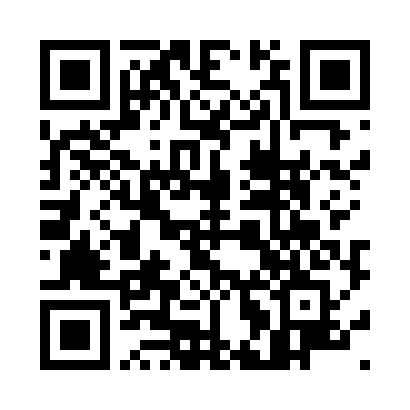

In [1]:
%pip install --upgrade qrcode Pillow
import qrcode
qr = qrcode.make("https://github.com/hammal/IMSE2025/blob/main/tutorial.ipynb")
display(qr)

### Installing Python Packages

The [cbadc](https://github.com/hammal/cbadc/tree/feature/0.4.0) package and all dependencies can directly be installed using the following [pip](https://packaging.python.org/en/latest/guides/tool-recommendations/) command

```bash
python -m pip install git+https://github.com/hammal/cbadc.git@feature/0.4.0
```

upon release this will be
``` bash
python -m pip install cbadc
```

In [2]:
%pip install git+https://github.com/hammal/cbadc.git@feature/0.4.0

  Cloning https://github.com/hammal/cbadc.git (to revision feature/0.4.0) to /private/var/folders/vy/xnxm11256b90khb3rff3247m0000gn/T/pip-req-build-pr7g4ivd
  Running command git clone --filter=blob:none --quiet https://github.com/hammal/cbadc.git /private/var/folders/vy/xnxm11256b90khb3rff3247m0000gn/T/pip-req-build-pr7g4ivd
  fatal: unable to access 'https://github.com/hammal/cbadc.git/': Recv failure: Operation timed out
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/hammal/cbadc.git /private/var/folders/vy/xnxm11256b90khb3rff3247m0000gn/T/pip-req-build-pr7g4ivd did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/hammal/cbadc.git /private/var/folders/vy/xnxm11256b90khb3rff3247m0000gn/T/pip-req-build-pr7g4ivd did not run success

## Design example for a continuous-time lowpass DS ADC

We will begin by reproducing much of the [dsexample2.m](https://se.mathworks.com/matlabcentral/fileexchange/19-delta-sigma-toolbox) from Schreier's delta sigma toolbox

We begin by instantiating all Python packages and some standard settings for plot sizes, numpy array printing formatting.

In [32]:
import numpy as np
import cbadc as cb
import matplotlib.pyplot as plt

plotsize = (8, 4) #inches
plt.rcParams['figure.figsize'] = plotsize

np.set_printoptions(precision=2, suppress=True)

#### Nominal Model Parameters

Note that we will decide for a bandwidth (Bw) and thereby sampling frequency (fs)
as this will make life easier when we later introduce component values.

In [4]:
order = 3
osr = 32
nlev = 2
f0 = 0.
Hinf = 1.5
tdac = [0, 1]
form = 'FB'
dt_form = 'CRFB'
Bw = 10e6
fs = Bw * osr * 2
print(f"fs = {fs/1e6} MHz")

fs = 640.0 MHz


We synthesize the discrete-time SDM and print zeros and poles

In [5]:
ntf0 = cb.delsig.synthesizeNTF(order, osr, 2, Hinf, f0) # 2: Optimized zero placement
# Extract zeros and poles from ntf0
zeros = ntf0.zeros
poles = ntf0.poles
for z, p in zip(ntf0.zeros, ntf0.poles):
    print("(%f, %fj)\t(%f, %fj)" % (np.real(z), np.imag(z), np.real(p), np.imag(p)))


(1.000000, 0.000000j)	(0.764515, -0.280052j)
(0.997110, 0.075973j)	(0.764515, 0.280052j)
(0.997110, -0.075973j)	(0.668460, 0.000000j)


For compatibility with the MATLAB delta sigma toolbox I have also included these standard visualization commands

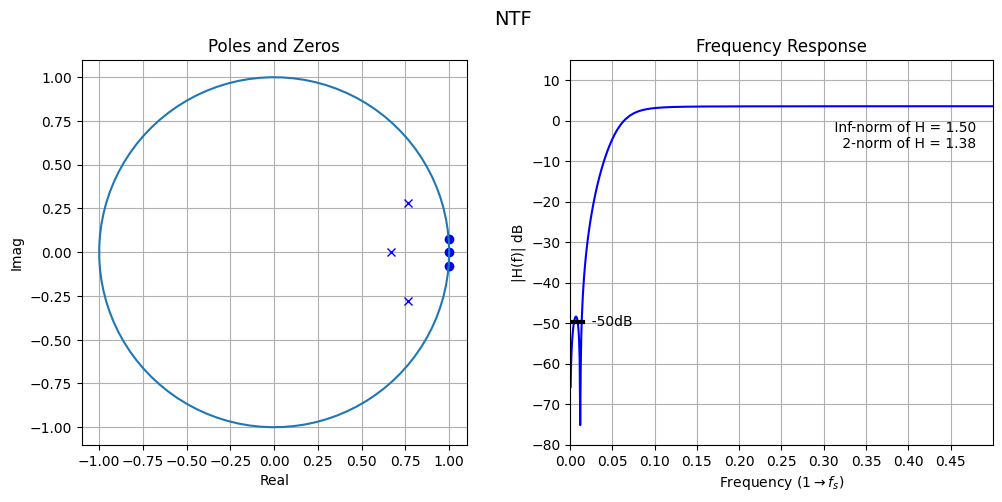

In [27]:
# Plot zeros and poles
# cb.delsig.plotPZ(ntf0, showlist=False)
# cb.delsig.changeFig(10, 1.5, 7)
cb.delsig.DocumentNTF(ntf0, osr, f0, False)

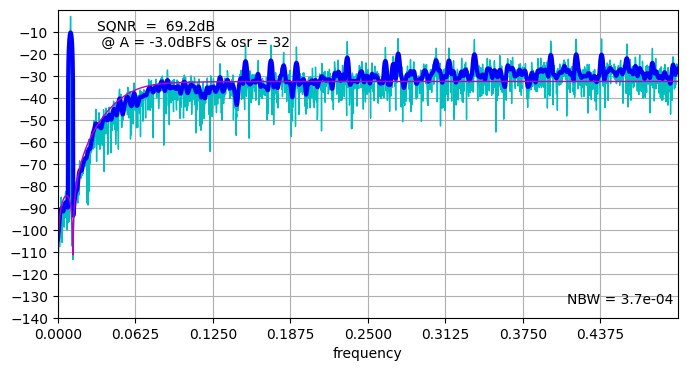

In [8]:
cb.delsig.PlotExampleSpectrum(ntf0, nlev-1, osr, f0)
# title('Example Spectrum');

### Commit to an Topology

My library starts when there is an actual set of differential or difference equations to relate to.

That is we need to realize the NTF

In [28]:
# decide for a architecture
a, g, b, c = cb.delsig.realizeNTF(ntf0, form="CRFB")
ABCD = cb.delsig.stuffABCD(a, g, b, c)
dt_analog_frontend = cb.AnalogFrontend.dtsdm(ABCD, nlev)
print(dt_analog_frontend)

AnalogFrontend(
  analog_filter=StateSpace(
A=
[[ 1.  0.  0.]
 [ 1.  1. -0.]
 [ 1.  1.  1.]],
B=
[[ 0.  -0. ]
 [ 0.2 -0.2]
 [ 0.8 -0.8]],
C=
[[0. 0. 1.]],
D=
[[1. 0.]]),
)
digital_control=DigitalControl(M=1, dt=1.0, dac_waveform=nrz),
analog_signal=AnalogSignal(offset=[[0.]], L=1, piecewise_constant=True),
state_covariance=None,
output_covariance=None,
N=3,
L=1,
M=1,
dt=1.0
)


As in [dsexample2.m](https://se.mathworks.com/matlabcentral/fileexchange/19-delta-sigma-toolbox) we next synthesize a CT-loop filter.

Note that we rescale the coefficients 
``` python
ct_analog_frontend.dt = 1.0/fs
```
This has no effect on the simulations relating to the CT-SDM.

In [10]:
ABCDc, tdac2 = cb.delsig.realizeNTF_ct(ntf0, form, tdac)
print(f"ABCDc = \n{ABCDc}")
print(f"tdac2 = {tdac2}")
ct_analog_frontend = cb.AnalogFrontend.ctsdm(ABCDc, tdac2, quantization_levels=nlev)
# rescale to fs
ct_analog_frontend.dt = 1.0/fs
print(ct_analog_frontend)

ABCDc = 
[[ 0.   0.   0.   0.  -0. ]
 [ 1.   0.  -0.   0.  -0.2]
 [ 0.   1.   0.   0.  -0.7]
 [ 0.   0.   1.   0.   0. ]]
tdac2 = [[-1. -1.]
 [ 0.  1.]]
AnalogFrontend(
  analog_filter=StateSpace(
A=
[[ 0.0e+00  0.0e+00  0.0e+00]
 [ 6.4e+08  0.0e+00 -3.7e+06]
 [ 0.0e+00  6.4e+08  0.0e+00]],
B=
[[ 2.8e+07 -2.8e+07]
 [ 0.0e+00 -1.5e+08]
 [ 0.0e+00 -4.3e+08]],
C=
[[0. 0. 1.]],
D=
[[0. 0.]]),
)
digital_control=DigitalControl(M=1, dt=1.5625e-09, dac_waveform=nrz),
analog_signal=AnalogSignal(offset=[[0.]], L=1, piecewise_constant=True),
state_covariance=None,
output_covariance=None,
N=3,
L=1,
M=1,
dt=1.5625e-09
)


/Users/hammal/Projects/IMSE2025/imse2025/lib/python3.13/site-packages/scipy/signal/_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)
/Users/hammal/Projects/IMSE2025/imse2025/lib/python3.13/site-packages/scipy/signal/_filter_design.py:1125: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


As a sanity check we convert the CT-SDM loop filter back into discrete-time to check that it agrees with the discrete-time counterpart.

In fact this is the standard way of simulating CT-SDM in the deltasigma toolbox. 

In [11]:
dt_ct_analog_frontend = ct_analog_frontend.discretize(dt=ct_analog_frontend.dt)
ABCD = dt_ct_analog_frontend.ABCD
print(dt_ct_analog_frontend)

AnalogFrontend(
  analog_filter=StateSpace(
A=
[[ 1.   0.   0. ]
 [ 1.   1.  -0. ]
 [ 0.5  1.   1. ]],
B=
[[ 0.  -0. ]
 [ 0.  -0.3]
 [ 0.  -0.8]],
C=
[[0. 0. 1.]],
D=
[[0. 0.]]),
)
digital_control=DigitalControl(M=1, dt=1.0, dac_waveform=nrz),
analog_signal=AnalogSignal(offset=[[0.]], L=1, piecewise_constant=True),
state_covariance=None,
output_covariance=None,
N=3,
L=1,
M=1,
dt=1.0
)


We compare with the original DT-SDM

In [29]:
print(dt_analog_frontend)

AnalogFrontend(
  analog_filter=StateSpace(
A=
[[ 1.  0.  0.]
 [ 1.  1. -0.]
 [ 1.  1.  1.]],
B=
[[ 0.  -0. ]
 [ 0.2 -0.2]
 [ 0.8 -0.8]],
C=
[[0. 0. 1.]],
D=
[[1. 0.]]),
)
digital_control=DigitalControl(M=1, dt=1.0, dac_waveform=nrz),
analog_signal=AnalogSignal(offset=[[0.]], L=1, piecewise_constant=True),
state_covariance=None,
output_covariance=None,
N=3,
L=1,
M=1,
dt=1.0
)


### Simulation

Instead of comparing poles, zeros, or impulse responses we go straight for simulations

These simulations are
- 25 input amplitudes simulated for
- a length of 2^(13) 
- That is ~4M output data points (~1.3M if you consider the states)

Concerning runtimes on my machine
- In MATLAB they are fast 0.18 seconds (that's compiled C code under the hood).
- In the Python [deltasigma port](http://www.python-deltasigma.io) they are slow 5 seconds.
- In our case see below.

In [12]:
snr_dt, amp_dt, _ = dt_analog_frontend.simulateSNR(osr)

INFO:root:Simulating discrete-time analog frontend


In [13]:
snr_ct, amp_ct, _ = ct_analog_frontend.simulateSNR(osr)

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


In [14]:
snr_dt_ct, amp_dt_ct, _ = dt_ct_analog_frontend.simulateSNR(osr)

INFO:root:Simulating discrete-time analog frontend


Let's visualize the results

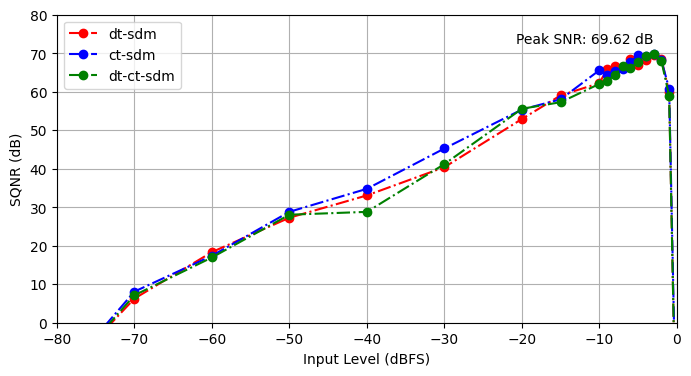

In [15]:
plt.plot(amp_dt, snr_dt, 'o-.r', label='dt-sdm')
plt.plot(amp_ct, snr_ct, 'o-.b', label='ct-sdm')
plt.plot(amp_dt_ct, snr_dt_ct, 'o-.g', label='dt-ct-sdm')
plt.xlabel('Input Level (dBFS)')
plt.ylabel('SQNR (dB)')
plt.grid()

peak_amp_dt = np.argmax(snr_dt)
plt.text(amp_dt[peak_amp_dt], snr_dt[peak_amp_dt] + 3, f'Peak SNR: {snr_dt[peak_amp_dt]:.2f} dB', horizontalalignment='right')
plt.xlim((-80, 0))
plt.ylim((0, 80))
plt.legend()


## GmC Integrators

![The GmC block](gmc_from_simsides.png)

This is work in process but I have started from something like the figure ahead.

In [16]:
Ro = np.ones(order) * 1e5
Cp = np.ones(order) * 1e-15
Cint = np.ones(order) * 1e-12
slew_rate = 1e9 * np.ones(order)
max_output_swing = 1.0 * np.ones(order)
min_output_swing = -max_output_swing
v_noise_rms = 1e-3 * np.ones(order)

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


AnalogFrontend(
  analog_filter=StateSpace(
A=
[[-1.0e+07  0.0e+00  0.0e+00]
 [ 6.4e+08 -1.0e+07 -3.7e+06]
 [ 0.0e+00  6.4e+08 -1.0e+07]],
B=
[[ 2.8e+07 -2.8e+07]
 [ 0.0e+00 -1.5e+08]
 [ 0.0e+00 -4.3e+08]],
C=
[[0. 0. 1.]],
D=
[[0. 0.]]),
)
digital_control=DigitalControl(M=1, dt=1.5625e-09, dac_waveform=nrz),
analog_signal=AnalogSignal(offset=[[0.]], L=1, piecewise_constant=True),
state_covariance=[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]],
output_covariance=None,
N=3,
L=1,
M=1,
dt=1.5625e-09
)


This is how you instantiate the model which returns a analog frontend much like the objects before but with additional capabilities when needed.

In [ ]:
GmC = cb.GmC(
    ct_analog_frontend, 
    Cint, 
    Ro, 
    Cp, 
    v_n=v_noise_rms, 
    slew_rate=slew_rate, 
    v_out_max=max_output_swing, 
    v_out_min=min_output_swing
)
snr_gmc, amp_gmc, _ = GmC.simulateSNR(osr)
print(GmC)

In [33]:
print(f"The GmC:\n{GmC.gm}")

The GmC:
[[ 0.  0.  0.  0. -0.]
 [ 0.  0. -0.  0. -0.]
 [ 0.  0.  0.  0. -0.]]


In [18]:
print(f"The DC_gain:\n{GmC.dc_gain}")

The DC_gain:
[[  0.    0.    0.    2.8  -2.8]
 [ 64.    0.   -0.4   0.  -15.4]
 [  0.   64.    0.    0.  -42.9]]


## Active RC Integrators

![The GmC block](active_rc_from_simsides.png)

In [35]:
Ro = 1e6 * np.ones(order)
Co = np.ones(order) * 1e-15
Cint = np.ones(order) * 1e-12
gm = 1e-5 * np.ones(order)
active_RC = cb.ActiveRC(
    ct_analog_frontend, 
    Cint, 
    gm, 
    Ro, 
    Co
)
print(active_RC)
snr_active_rc, amp_active_rc, _ = active_RC.simulateSNR(osr)

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


AnalogFrontend(
  analog_filter=StateSpace(
A=
[[-1.00e+10  0.00e+00  0.00e+00 -1.00e+09 -0.00e+00 -0.00e+00]
 [ 0.00e+00 -1.06e+10  0.00e+00 -6.40e+08 -1.00e+09  3.70e+06]
 [ 0.00e+00  0.00e+00 -1.06e+10 -0.00e+00 -6.40e+08 -1.00e+09]
 [-1.00e+10 -0.00e+00 -0.00e+00 -1.00e+09 -0.00e+00 -0.00e+00]
 [-0.00e+00 -1.00e+10 -0.00e+00 -0.00e+00 -1.00e+09 -0.00e+00]
 [-0.00e+00 -0.00e+00 -1.00e+10 -0.00e+00 -0.00e+00 -1.00e+09]],
B=
[[ 2.84e+07 -2.84e+07]
 [ 0.00e+00 -1.54e+08]
 [ 0.00e+00 -4.29e+08]
 [ 0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00]],
C=
[[ 0.  0.  0. -0. -0. -1.]],
D=
[[0. 0.]]),
)
digital_control=DigitalControl(M=1, dt=1.5625e-09, dac_waveform=nrz),
analog_signal=Sinusoidal parameterized as:
amplitude = [[1.]],
frequency = [[5000000.]],
phase = [[0.]],
offset = [[0.]],
state_covariance=None,
output_covariance=None,
N=6,
L=1,
M=1,
dt=1.5625e-09
)


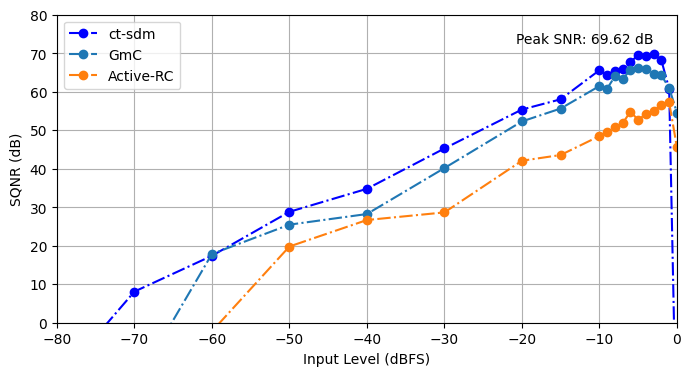

In [20]:
# plt.plot(amp_dt, snr_dt, 'o-.r', label='dt-sdm')
plt.plot(amp_ct, snr_ct, 'o-.b', label='ct-sdm')
# plt.plot(amp_dt_ct, snr_dt_ct, 'o-.g', label='dt-ct-sdm')
plt.plot(amp_gmc, snr_gmc, 'o-.', label='GmC')
plt.plot(amp_active_rc, snr_active_rc, 'o-.', label='Active-RC')
plt.xlabel('Input Level (dBFS)')
plt.ylabel('SQNR (dB)')
plt.grid()

peak_amp_dt = np.argmax(snr_dt)
plt.text(amp_dt[peak_amp_dt], snr_dt[peak_amp_dt] + 3, f'Peak SNR: {snr_dt[peak_amp_dt]:.2f} dB', horizontalalignment='right')
plt.xlim((-80, 0))
plt.ylim((0, 80))
plt.legend()


Let's take a closer look on some transient simulations

In [21]:
size = 1 << 14

amplitude = np.array([[1.0]], dtype=float)
freq = np.array([[GmC.fs / 128]], dtype=float)
sinusoidal = cb.Sinusoidal(amplitude, freq)
print(sinusoidal)
GmC.analog_signal = sinusoidal
ct_analog_frontend.analog_signal = sinusoidal
active_RC.analog_signal = sinusoidal
# ct_analog_frontend.A += - 1e-7 * np.eye(order)

ct_af_sim = ct_analog_frontend.simulate(size)
gmc_sim = GmC.simulate(size)
active_RC_sim = active_RC.simulate(size)

ct_wiener_filter = ct_analog_frontend.wiener_filter(OSR=osr)
ct_u_hat = ct_wiener_filter.evaluate(ct_af_sim["s"])[:, 0, :]

gmc_wiener_filter = GmC.wiener_filter(OSR=osr)
gmc_u_hat = gmc_wiener_filter.evaluate(gmc_sim["s"])[:, 0, :]

active_rc_wiener_filter = active_RC.wiener_filter(OSR=osr)
active_rc_u_hat = active_rc_wiener_filter.evaluate(active_RC_sim["s"])[:, 0, :]

INFO:root:Simulating continuous-time analog frontend for sinusoidal input


Sinusoidal parameterized as:
amplitude = [[1.]],
frequency = [[5000000.]],
phase = [[0.]],
offset = [[0.]]


INFO:root:Simulating continuous-time analog frontend for sinusoidal input
INFO:root:Simulating continuous-time analog frontend for sinusoidal input


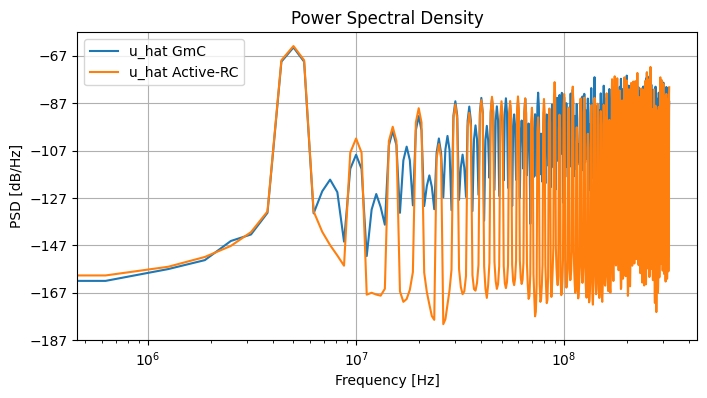

In [22]:
plt.figure()
# plt.psd(ct_af_sim["s"].flatten(), NFFT=1024, Fs=1 / ct_analog_frontend.dt, label="u_hat ideal")
plt.psd(gmc_sim["s"].flatten(), NFFT=1024, Fs=1 / GmC.dt, label="u_hat GmC")
plt.psd(active_RC_sim["s"].flatten(), NFFT=1024, Fs=1 / active_RC.dt, label="u_hat Active-RC")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [dB/Hz]")
plt.title("Power Spectral Density")
plt.xscale("log")

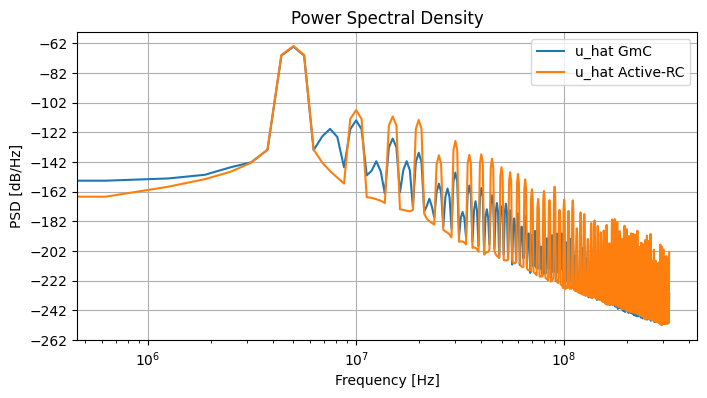

In [23]:
plt.figure()
# plt.psd(ct_u_hat.flatten(), NFFT=1024, Fs=1 / ct_analog_frontend.dt, label="u_hat ideal")
plt.psd(gmc_u_hat.flatten(), NFFT=1024, Fs=1 / GmC.dt, label="u_hat GmC")
plt.psd(active_rc_u_hat.flatten(), NFFT=1024, Fs=1 / active_RC.dt, label="u_hat Active-RC")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [dB/Hz]")
plt.title("Power Spectral Density")
plt.xscale("log")

Text(0, 0.5, 'Input')

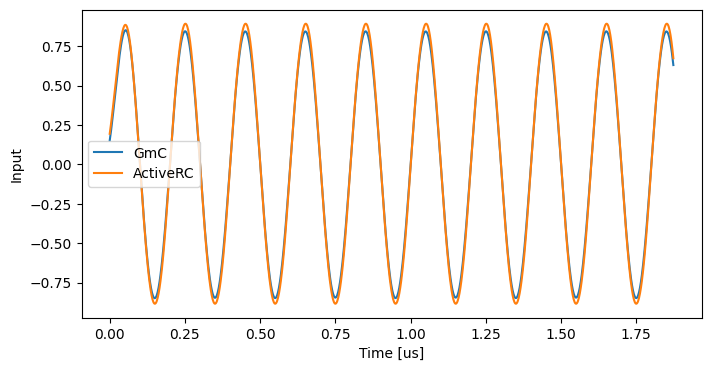

In [24]:
plt.figure()
length = 1200
# plt.plot(1e6 * ct_af_sim["t"][:length], ct_u_hat[:length], label="ideal")
plt.plot(1e6 * gmc_sim["t"][:length], gmc_u_hat[:length], label="GmC")
plt.plot(1e6 * active_RC_sim["t"][:length], active_rc_u_hat[:length], label="ActiveRC")
plt.legend()
plt.xlabel("Time [us]")
plt.ylabel("Input")

In [25]:
active_RC.simulateNGSpice(...)

AttributeError: 'ActiveRC' object has no attribute 'simulateNGSpice'

## Outlook

Many features pending
- More advanced simulation reporting,
  - max currents,
  - max voltages,
  - ...
- FIR DAC support (implemented but has a bug)
- Refined GmC, activeRC parametrization and documentation
- MASH design flow
- Pipeline design flow
- ...

Also Validation against spice models